# PreProcessing Demonstration

In this notebook, we will explore the PyTorch Dataset class and show how it can be used to handle input images. It should do some light preprocessing to make sure everything is available. 

Some things to note:
* checks to see that there is a 1-to-1 correspondence between the datasets
* does the tiling
* exports tiles that are extra

In [1]:
# Helpful trick for loading the directories correction
import sys, os
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))


from src.data.worldfloods.dataset import WorldFloodsDataset

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Load Demo Image

For this demonstration, we need a S2 AND a groundtruth image. We have two that we can download.

In [2]:
from src.data.worldfloods.dataset import WorldFloodsImage
from src.data.worldfloods.download import download_image, get_image_path
from src.data.utils import download_data_from_bucket
from pathlib import Path

gs_index = "gs://"
bucket_id = "ml4floods"
path = "worldfloods/public/"
sub_dir = "train/S2"
file_name = "01042016_Holmes_Creek_at_Vernon_FL.tif"


# ============
# DATAIMAGE
# ============

# filename
file_name = "ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif"

# initialize the dataclass (specific to the worldfloods images)
dc_image_example = WorldFloodsImage(filename=file_name)

# to see
print(dc_image_example)

# download image from bucket
destination_dir = Path(root).joinpath("datasets/trials/image/S2")
download_image(dc_image_example, destination_dir)


# ============
# GROUND TRUTH IMAGE
# ============

# filename
file_name = "ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif"

# initialize the dataclass (specific to the worldfloods images)
dc_gt_example = WorldFloodsImage(filename=file_name)
print(dc_gt_example)

# download image from bucket
destination_dir = Path(root).joinpath("datasets/trials/image/gt")
download_image(dc_gt_example, destination_dir)

WorldFloodsImage(filename='ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif', uri=None, filepath=None, bucket_id=None, product_id=None, load_date=datetime.datetime(2021, 2, 18, 16, 59, 48, 879862), source_system='Not Specified')
Folder '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/S2' Is Already There.
WorldFloodsImage(filename='ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif', uri=None, filepath=None, bucket_id=None, product_id=None, load_date=datetime.datetime(2021, 2, 18, 16, 59, 48, 879862), source_system='Not Specified')
Folder '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt' Is Already There.


In [3]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/S2
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt

01042016_Holmes_Creek_at_Vernon_FL.tif
01042016_Holmes_Creek_at_Vernon_FL.tif


## Outline the Immediate Steps

* check for file correspondence between the directories

## Initialize PyTorch Dataset

In [4]:
import os
import random
from pathlib import Path
from typing import Callable, List, Optional, Tuple

import numpy as np
import rasterio
import rasterio.windows
from torch.utils.data import Dataset

from src.data.utils import check_path_exists
from src.data.worldfloods.configs import CHANNELS_CONFIGURATIONS
from src.data.worldfloods.prepare_data import prepare_data_func


from dataclasses import dataclass, field
from datetime import datetime
from typing import List, Dict



class WorldFloodsDataset(Dataset):
    """
    A dataloader for the WorldFloods dataset.

    Args:
        image_files (List[str]): size of the tiling window
        image_prefix (str): the subdirectory name for the images
        gt_prefix (str): the subdirectory name for the groundtruth
        
    Attributes:
        
    """
    def __init__(
        self,
        image_files: List[str],
        image_prefix: str = "/images/",
        gt_prefix: str = "/gt/",
    ):

        self.image_files = image_files
        self.image_prefix = image_prefix
        self.gt_prefix = gt_prefix

        # sort to make sure that the order is deterministic
        # (order of the flow of data points to the ML model)
        # TODO: Do this for the list of filepaths at the end as well
        self.image_files.sort()




In [6]:
image_files = ["/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/S2/01042016_Holmes_Creek_at_Vernon_FL.tif"]

train_dataset = WorldFloodsDataset(
    image_files=image_files,
)
type(train_dataset)

__main__.WorldFloodsDataset

## 1 - Open Image

First, we can access the rasterio dataset and get access to some of the attributes. The most important one for now is the `height` and `width`.

**Source**: [StackOverFlow](https://gis.stackexchange.com/questions/285499/how-to-split-multiband-image-into-image-tiles-using-rasterio)

In [8]:
with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    print(dataset)
    print(type(dataset))
    print(f"Height: {dataset.meta['height']}")
    print(f"Width: {dataset.meta['width']}")

<open DatasetReader name='gs://ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif' mode='r'>
<class 'rasterio.io.DatasetReader'>
Height: 1980
Width: 2841


### Visualize Image

We can use the tried and true rasterio.

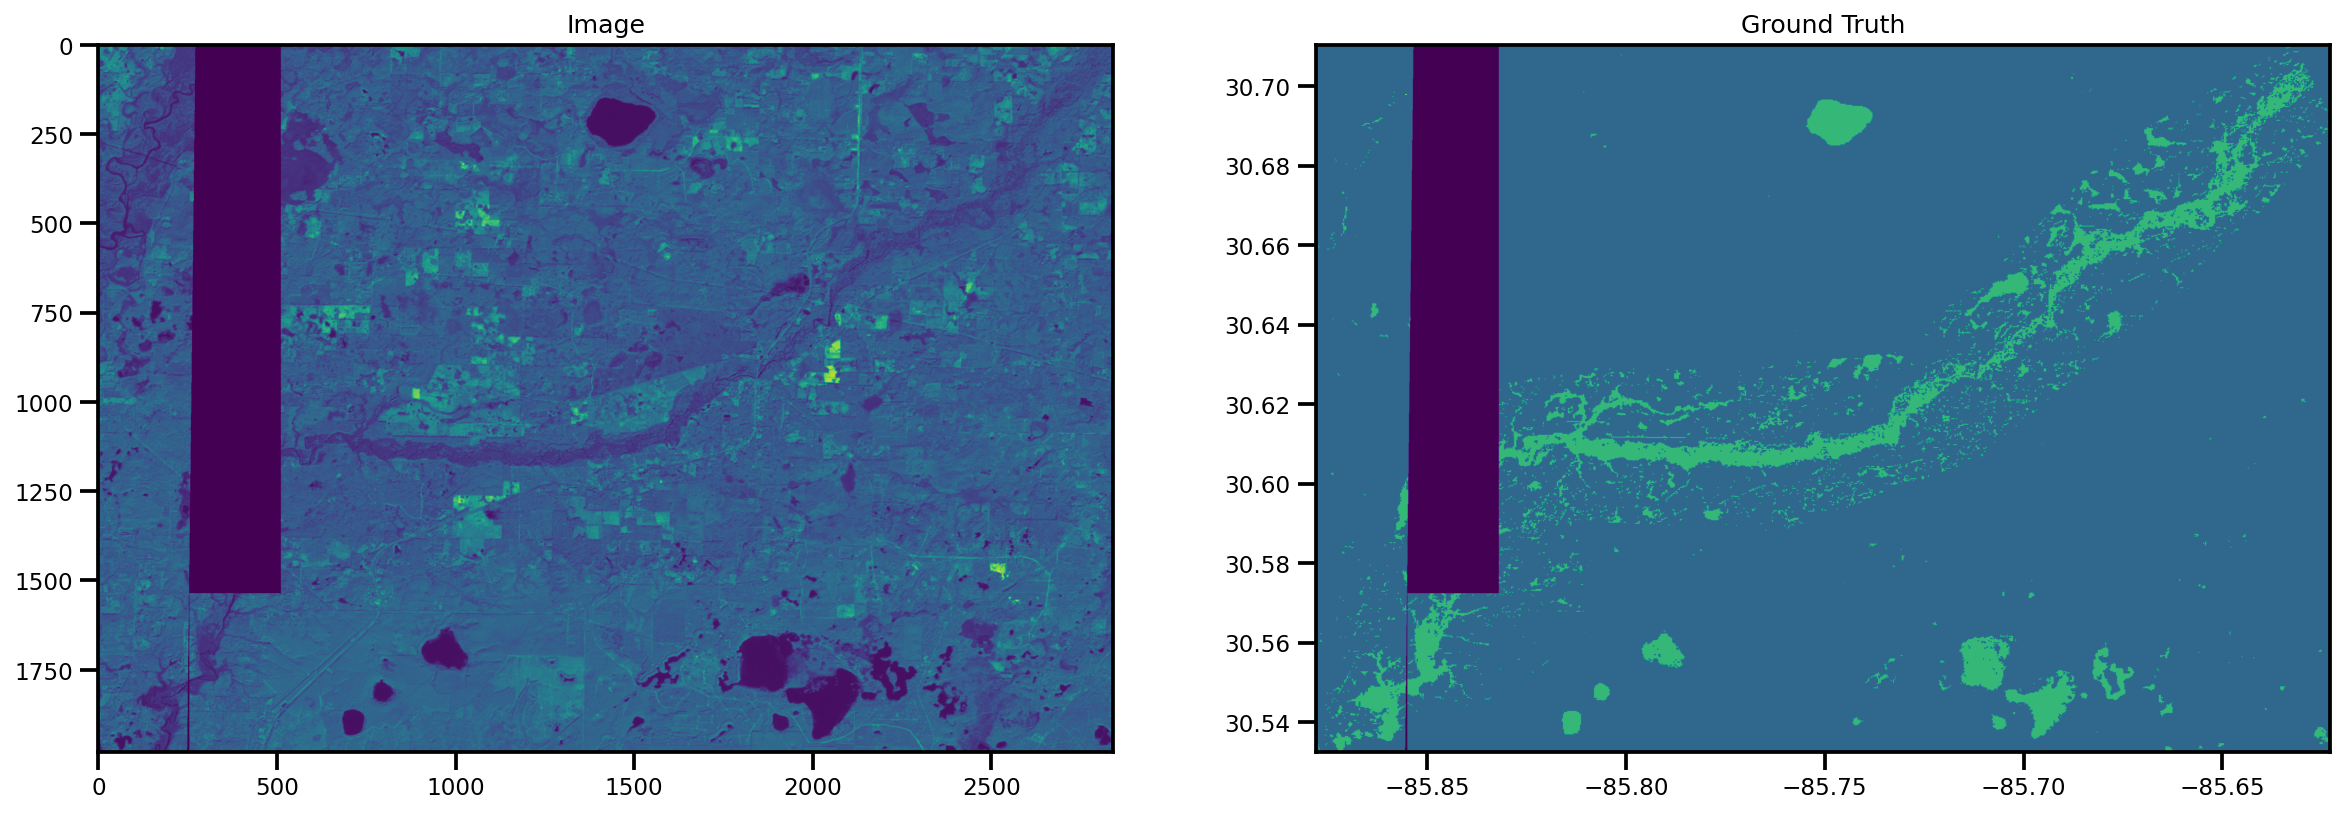

In [14]:
from rasterio.plot import show as rasterio_show

band = 6 # it shows better land features

fig, ax = plt.subplots(ncols=2, figsize=(20,10))
with rasterio.open("gs://"+get_image_path(dc_image_example)) as dataset:
    rasterio_show(
        dataset.read(indexes=band), ax=ax[0],)
    ax[0].set_title("Image",)

with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    rasterio_show(dataset, ax=ax[1])
    ax[1].set_title("Ground Truth",)
    
plt.show()

## Tiling

For ML, often we want to use a subset of the original image, aka tiles. For our purposes, we're going to be tiling indiscriminantly, i.e. we are not concerned about geocoordinates. All we care about is that the windowsize is smaller then the images.

In [97]:
from src.preprocess.tiling import get_window_tiles

In [72]:
from rasterio.io import DatasetReader
from itertools import product
from rasterio import windows
import rasterio


def get_window_tiles(
    ds: rasterio.io.DatasetReader, height: int = 128, width: int = 128, **kwargs
) -> rasterio.windows.Window:
    """a generator for rasterio specific slices given a rasterio dataset

    Args:
        ds (rasterio.io.DatasetReader): a rasterio dataset object
        height (int): the height for the slice
        width (int): the width for the slice

    Yields:
        window (rasterio.windows.Window): slicing
    """
    # extract the row height from the dataset
    n_columns, n_rows = ds.meta["width"], ds.meta["height"]

    # create the offsets
    offsets = product(range(0, n_columns, width), range(0, n_rows, height))

    for col_offset, row_offset in offsets:
        window = windows.Window(
            col_off=col_offset,
            row_off=row_offset,
            width=width,
            height=height,
        )
        yield window


In [45]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 2841,
 'height': 1980,
 'count': 13,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, -85.87804284654213,
        0.0, -8.983152841195215e-05, 30.710435123608846)}

In [70]:
def get_tiles(
    ds: rasterio.io.DatasetReader, height: int = 128, width: int = 128, **kwargs
) -> rasterio.windows.Window:
    """a generator for rasterio specific slices given a rasterio dataset

    Args:
        ds (rasterio.io.DatasetReader): a rasterio dataset object
        height (int): the height for the slice
        width (int): the width for the slice

    Yields:
        window (rasterio.windows.Window): slicing
    """
    # extract the row height from the dataset
    n_columns, n_rows, n_channels = ds.meta["width"], ds.meta["height"], ds.meta["count"]

    # create the offsets
    offsets = product(range(0, n_columns, width), range(0, n_rows, height))

    for col_offset, row_offset in offsets:
        window = windows.Window(
            col_off=col_offset,
            row_off=row_offset,
            width=width,
            height=height,
        )
        sub_image = ds.read(window=window, **kwargs)
#         print(sub_image.dtype)
        
        # if the window-size is not good
        # TODODODODODODOD! FIX MEEEEE
        if sub_image.shape != (n_channels, height, width):
            continue
            
        # if the window-size is good, give me the image
        else:
            yield sub_image


with rasterio.open("gs://"+get_image_path(dc_image_example)) as dataset:
    t = dataset.read(indexes=1)
    
#     for sub_image in get_tiles(dataset, 128, 128):
# #         print(sub_image)
#         print(sub_image.shape)
#         break
        

In [71]:
t.shape

(1980, 2841)

RasterioIOError: Dataset is closed: gs://ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif

In [41]:
with rasterio.open("gs://"+get_image_path(dc_image_example)) as dataset:
    t = next(get_tiles(dataset, 128, 128))

StopIteration: 

In [ ]:
t

In [22]:
with rasterio.open("gs://"+get_image_path(dc_image_example)) as dataset:
    print(type(dataset))
    print(dataset.meta)


<class 'rasterio.io.DatasetReader'>
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2841, 'height': 1980, 'count': 13, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, -85.87804284654213,
       0.0, -8.983152841195215e-05, 30.710435123608846)}


In [23]:
ds

array([[   0,    0,    0, ...,    0,    0,    0],
       [2353, 2276, 2276, ..., 1431, 1316, 1316],
       [2353, 2276, 2276, ..., 1276, 1399, 1399],
       ...,
       [1215, 1604, 1604, ..., 1180, 1328, 1328],
       [1322, 1712, 1712, ..., 1180, 1328, 1328],
       [1322, 1712, 1712, ..., 1403, 1357, 1357]], dtype=uint16)

### Quick Demo

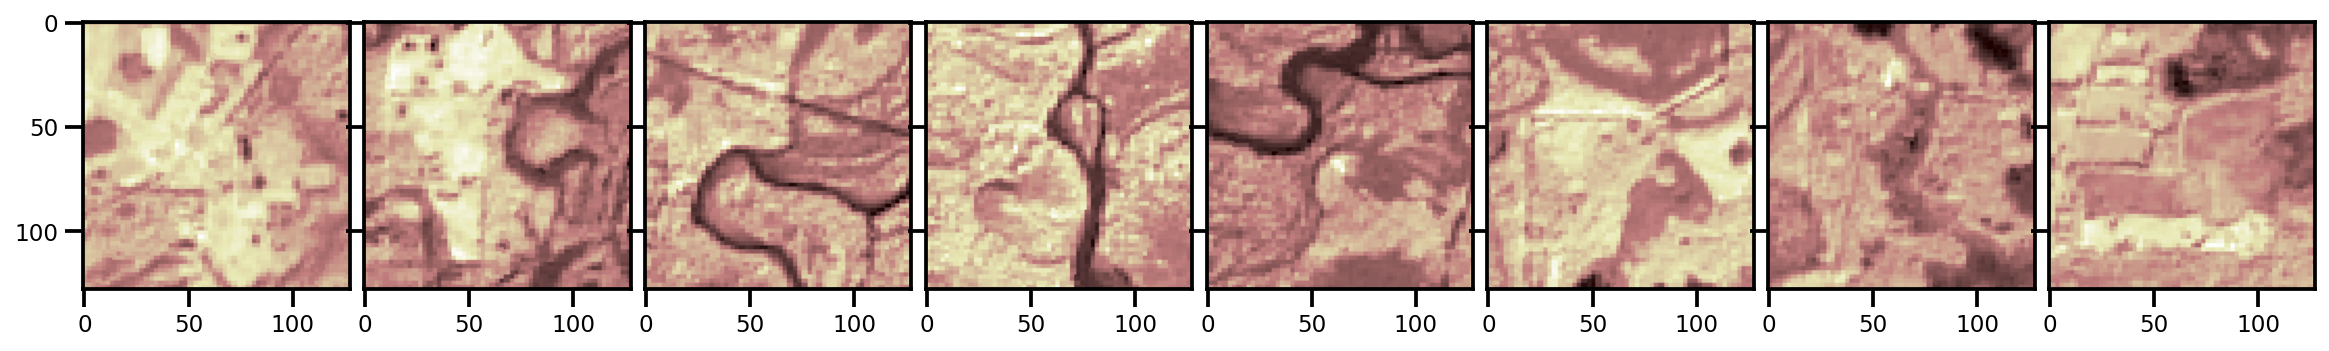

In [81]:
from rasterio.plot import show as rasterio_show
from mpl_toolkits.axes_grid1 import ImageGrid

n_tiles = 8
iteration = 0

# plot preamble
fig = plt.figure(figsize=(20., 30.))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(1, n_tiles),
    axes_pad=0.1,
)

bands = [6,]



with rasterio.open("gs://"+get_image_path(dc_image_example)) as dataset:
    
    for iax, window in zip(grid, get_window_tiles(dataset, 128, 128)):

        # open the dataset with only the window selected
        sub_image = dataset.read(indexes=bands, window=window)


        
        if sub_image.shape != (len(bands), 128, 128):
            continue
            
        # display demo image
        rasterio_show(sub_image, ax=iax, cmap="pink")
    
        iteration += 1
        
        # stop the iteration once we've reached the classes
        if iteration == n_tiles:
            break

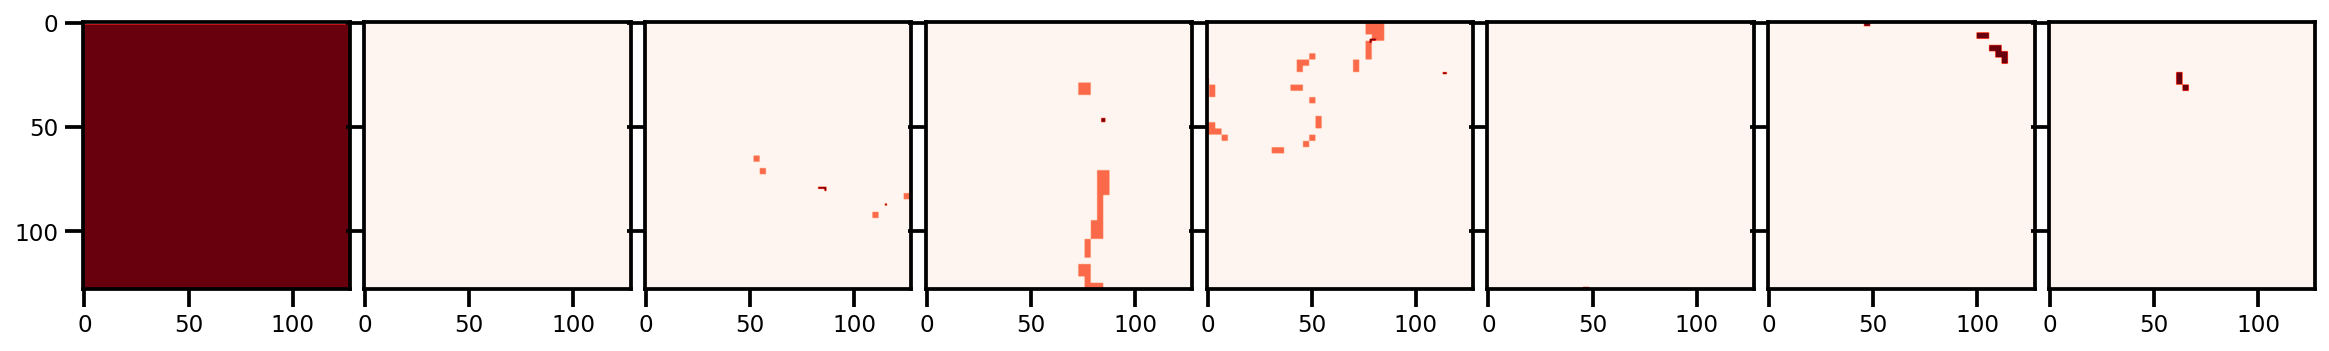

In [86]:
from rasterio.plot import show as rasterio_show
from mpl_toolkits.axes_grid1 import ImageGrid

n_tiles = 8
iteration = 0

fig = plt.figure(figsize=(20., 30.))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(1, n_tiles),
    axes_pad=0.1,
)
bands = [1,]



with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    
    for iax, window in zip(grid, get_window_tiles(dataset, 128, 128)):

        # open the dataset with only the window selected
        sub_image = dataset.read(indexes=bands, window=window)


        # equal tiling
        if sub_image.shape != (len(bands), 128, 128):
            continue
            
        # display demo image
        rasterio_show(sub_image, ax=iax, cmap="Reds")
    
        iteration += 1
        
        # stop the iteration once we've reached the classes
        if iteration == n_tiles:
            break

### Saving the Tiles

##### IMAGES

In [87]:
!rm -rf /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/
!mkdir /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/

S2  gt
S2  gt	image_tiles


In [88]:
# output directory
output_tile_dir = "/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/"
file_name = "01042016_Holmes_Creek_at_Vernon_FL"

n_tiles = 16
itile = 0



bands = [6,]



with rasterio.open("gs://"+get_image_path(dc_image_example)) as dataset:
    
    # copy the metadata
    window_meta = dataset.meta.copy()
    
    for iax, window in zip(grid, get_window_tiles(dataset, 128, 128)):
        
        # copy the meta data
        window_meta["width"] = window.width
        window_meta["height"] = window.height
        window_meta["channels"] = bands

        # open the dataset with only the window selected
        sub_image = dataset.read(indexes=bands, window=window)
        
        if sub_image.shape != (len(bands), 128, 128):
            continue
        else:
            # create unique filename for the tile
            window_file_name = f"{file_name}_tile_{itile}.tif"
            
            # filepath for saving
            output_tile_file_name = str(Path(output_tile_dir).joinpath(window_file_name))
            
            # open file and also save meta data
            with rasterio.open(output_tile_file_name, "w", **window_meta) as out_f:
                out_f.write(dataset.read(window=window))
            
    
        itile += 1
        
        # stop the iteration once we've reached the classes
        if itile == n_tiles:
            print('Reached # of iterations...Stopping')
            break

In [89]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_2.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_3.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_4.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_5.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_6.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_7.tif


## Ground Truth Demo

In [90]:
!rm -rf /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/
!mkdir /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles/
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/

S2  gt	image_tiles
S2  gt	gt_tiles  image_tiles


In [92]:
# output directory
output_tile_dir = "/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles/"
file_name = "01042016_Holmes_Creek_at_Vernon_FL"

n_tiles = 16
itile = 0



bands = [1,]



with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    
    # copy the metadata
    window_meta = dataset.meta.copy()
    
    for iax, window in zip(grid, get_window_tiles(dataset, 128, 128)):
        
        # copy the meta data
        window_meta["width"] = window.width
        window_meta["height"] = window.height
        window_meta["channels"] = bands

        # open the dataset with only the window selected
        sub_image = dataset.read(indexes=bands, window=window)
        
        if sub_image.shape != (len(bands), 128, 128):
            continue
        else:
            # create unique filename for the tile
            window_file_name = f"{file_name}_tile_{itile}.tif"
            
            # filepath for saving
            output_tile_file_name = str(Path(output_tile_dir).joinpath(window_file_name))
            
            # open file and also save meta data
            with rasterio.open(output_tile_file_name, "w", **window_meta) as out_f:
                out_f.write(dataset.read(window=window))
            
    
        itile += 1
        
        # stop the iteration once we've reached the classes
        if itile == n_tiles:
            print('Reached # of iterations...Stopping')
            break

In [93]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles/

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_2.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_3.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_4.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_5.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_6.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_7.tif


### Potential Improvements

So this can be very slow if we need to call this many times. Generators are nice as they do save on memory, however, I can see this being slow if we want to use this to do many calls. 

---
#### 1 - Concurrent Processing

This will allow us to read and write concurrently. It will be a much faster method.

**Source**: [Rasterio Docs](https://rasterio.readthedocs.io/en/latest/topics/concurrency.html)

---
#### 2 - Better Naming Convention

All I did was create a simple naming scheme via some order. But it would be nice to have that already done.

---

#### 3 - ML-Style saving

For ML tasks, it is necessary

---
#### 4 - Transformations

When we grab the tiles, we may want to do some sort of transformation. That will require more work for the application. But that transformation should be embedded within the actual tile extraction. 

## ML Loading Demo

#### All files in directory

In [96]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles/

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_2.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_3.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_4.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_5.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_6.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_7.tif


In [119]:
directory = "/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/"
p = Path(directory).glob('*.tif')
files = [str(x) for x in p if x.is_file()]
files

['/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_14.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_8.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_3.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_5.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_15.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_6.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_12.tif',
 '/ho

In [123]:
image_prefix = "image_tiles"
gt_prefix = "gt_tiles"
files[0].replace(image_prefix, gt_prefix, 1)

'/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_14.tif'

In [116]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_10.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_11.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_12.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_13.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_14.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_15.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_2.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_3.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_4.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_5.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_6.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_7.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_8.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_9.tif


In [117]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_10.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_11.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_12.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_13.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_14.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_15.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_2.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_3.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_4.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_5.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_6.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_7.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_8.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_9.tif


In [115]:
# get groundtruth directory
path_dir = Path("/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles")
image_parent = path_dir.parent
print(image_parent)
t = path_dir.replace(image_parent.parent / "image/gt_tiles")

/home/jemanjohnson34/projects/ml4floods/datasets/trials/image


OSError: [Errno 39] Directory not empty: '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles' -> '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles'

In [ ]:
directory = "/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/"
image_prefix = ""
all_file_names = Path()

In [143]:
class WorldFloodsDataset(Dataset):
    """
    A dataloader for the WorldFloods dataset.

    Attributes
    ----------
    window_size: tuple(int, int)
            size of the tiling window
    image_prefix: str
            the subdirectory name for the images
    gt_prefix: str
            the subdirectory name for the groundtruth

    """

    def __init__(
        self,
        image_files: List[str],
        image_prefix: str = "/image_files/",
        gt_prefix: str = "/gt_files/",
    ):

        self.image_files = image_files
        self.image_prefix = image_prefix
        self.gt_prefix = gt_prefix


        # sort to make sure that the order is deterministic
        # (order of the flow of data points to the ML model)
        # TODO: Do this for the list of filepaths at the end as well
        self.image_files.sort()

    def __getitem__(self, idx):
        
        # get filenames
        x_name = self.image_files[idx]
        y_name = x_name.replace(self.image_prefix, gt_prefix, 1)
        
        # Open Image File
        with rasterio.open(x_name) as f:
            x_tif = f.read(1)
            
        # Open Ground Truth File
        with rasterio.open(y_name) as f:
            y_tif = f.read(1)
        
        # get the channels
        return x_tif, y_tif

In [148]:
def get_files_in_directory(directory: str, suffix: str) -> List[str]:
    p = Path(directory).glob(f'*{suffix}')
    files = [str(x) for x in p if x.is_file()]
    return files

def get_filenames_in_directory(directory: str, suffix: str) -> List[str]:
    p = Path(directory).glob(f'*{suffix}')
    files = [str(x.name) for x in p if x.is_file()]
    return files

In [145]:
image_prefix = "image_tiles"
gt_prefix = "gt_tiles"
pt_ds = WorldFloodsDataset(files, image_prefix, gt_prefix)

In [146]:
x, y = pt_ds[10]

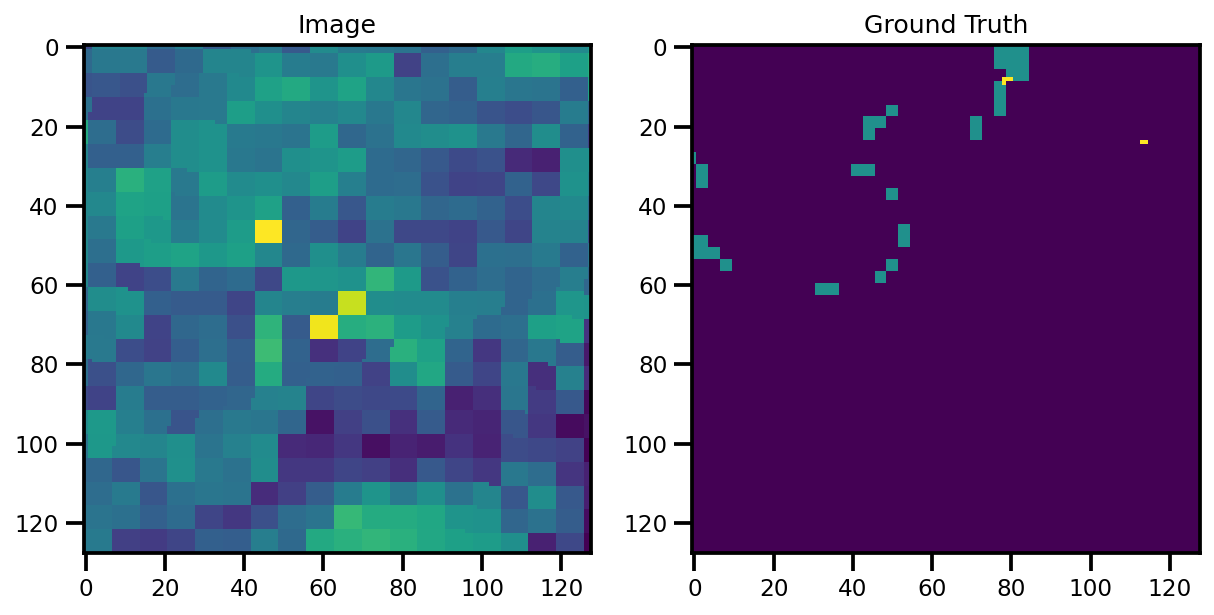

In [147]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2)

ax[0].imshow(x)
ax[0].set_title("Image")

ax[1].imshow(y)
ax[1].set_title("Ground Truth")

plt.show()